In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# 1. Data Loading and Feature Engineering
data = yf.download('SOL-USD', start='2022-01-01')

data['EMA'] = data['Close'].ewm(span=7, adjust=False).mean()
data['STD'] = data['Close'].rolling(window=7).std()
data['MA7'] = data['Close'].rolling(window=7).mean()
data['MA21'] = data['Close'].rolling(window=21).mean()

data = data.dropna()

features = ['Close', 'EMA', 'STD', 'MA7', 'MA21']
dataset = data[features].values

# 2. Dataset Creation
look_back = 14
def create_dataset(data, look_back=7):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, :])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# 3. Scaling (Fit ONLY on training data)
scaler = MinMaxScaler(feature_range=(0, 1))

# 4. Data Splitting (Train/Test Split)
train_size = int(len(dataset) * 0.8)
train_data_raw = dataset[:train_size]
test_data_raw = dataset[train_size:]

scaled_data = scaler.fit_transform(train_data_raw)

X_train, y_train = create_dataset(scaled_data, look_back=look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

test_data_scaled = scaler.transform(test_data_raw)

X_test, y_test = create_dataset(test_data_scaled, look_back=look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))


# 5. Model Building and Training (with early stopping)
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])



[*********************100%***********************]  1 of 1 completed
2025-02-05 11:09:09.051190: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-02-05 11:09:09.051276: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-02-05 11:09:09.051308: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-02-05 11:09:09.051353: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-05 11:09:09.051385: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/anaconda3/envs/deeplearning-env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: D

Epoch 1/100


2025-02-05 11:09:09.831251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0074 - val_loss: 0.0079
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020 - val_loss: 0.0066
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019 - val_loss: 0.0067
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014 - val_loss: 0.0094
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011 - val_loss: 0.0113
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.8425e-04 - val_loss: 0.0034
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011 - val_loss: 0.0089
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.7015e-04 - val_loss: 0.0141
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - l

In [7]:
# 6. Prediction Loop for Next 7 Days
n_predictions = 7
predictions = []
future_dates = []

prediction_data = data.copy()  # Copy of original *unscaled* data

for i in range(n_predictions):
    # *** KEY CORRECTION: Fill initial data correctly ***
    if len(prediction_data) < look_back:
        needed_rows = look_back - len(prediction_data)
        fill_data = data.tail(look_back + needed_rows).iloc[-needed_rows:] # Take enough rows to calculate features later
        prediction_data = pd.concat([prediction_data, fill_data])

    prediction_dataset = prediction_data[features].values
    prediction_scaled_data = scaler.transform(prediction_dataset)

    last_lookback_days = prediction_scaled_data[-look_back:]
    X_pred = np.array([last_lookback_days])
    X_pred = np.reshape(X_pred, (X_pred.shape[0], X_pred.shape[1], X_pred.shape[2]))
    predicted_data_scaled = model.predict(X_pred)

    dummy_data = np.zeros((1, dataset.shape[1]))
    dummy_data[0, 0] = predicted_data_scaled[0, 0]
    predicted_price_full = scaler.inverse_transform(dummy_data)
    predicted_price = predicted_price_full[0, 0]
    predictions.append(predicted_price)

    next_date = prediction_data.index[-1] + pd.Timedelta(days=1)
    new_row = pd.DataFrame({'Close': predicted_price}, index=[next_date])
    prediction_data = pd.concat([prediction_data, new_row])

    # Recalculate features (same as before)
    temp_data = prediction_data.copy()
    temp_data['EMA'] = temp_data['Close'].ewm(span=7, adjust=False).mean()
    temp_data['STD'] = temp_data['Close'].rolling(window=7).std()
    temp_data['MA7'] = temp_data['Close'].rolling(window=7).mean()
    temp_data['MA21'] = temp_data['Close'].rolling(window=21).mean()

    prediction_data = temp_data.dropna()

    future_dates.append(next_date)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/var/folders/cj/7jh5n4rs0_1c0m8b3059wx000000gn/T/ipykernel_87387/1822748358.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(x, y, f'{float(y):.2f}', ha='center', va='bottom', fontsize=8)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


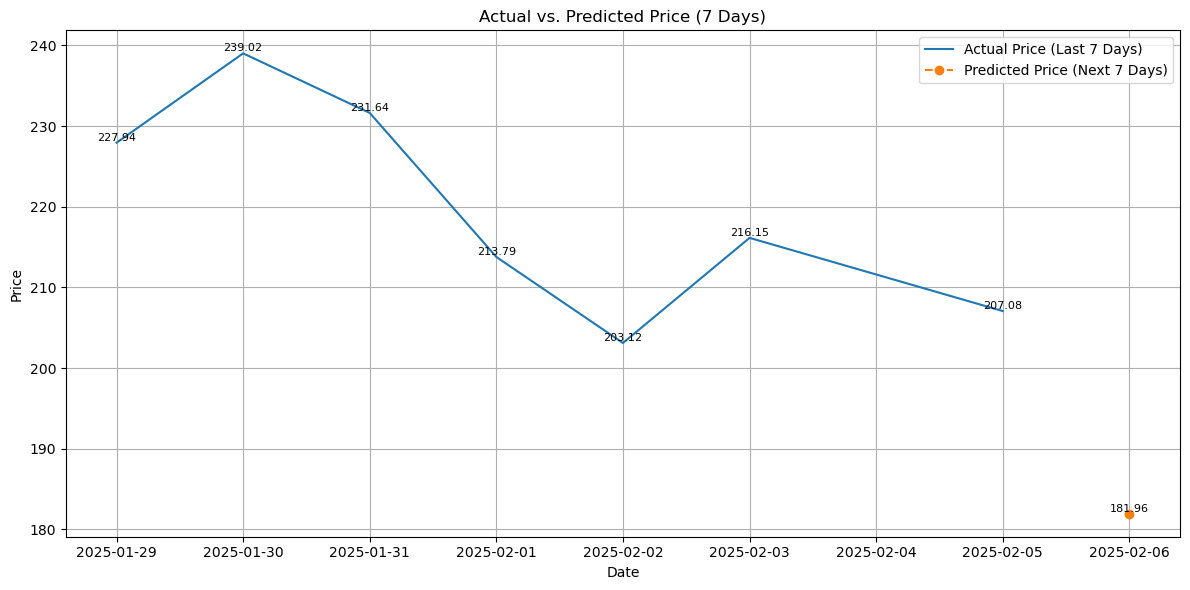

In [9]:
# 7. Plotting
plt.figure(figsize=(12, 6))

last_7_days = data['Close'].tail(7)

plt.plot(last_7_days.index, last_7_days.values, label='Actual Price (Last 7 Days)')
plt.plot(future_dates, predictions, label='Predicted Price (Next 7 Days)', marker='o', linestyle='--')

for x, y in zip(last_7_days.index, last_7_days.values):
    plt.text(x, y, f'{float(y):.2f}', ha='center', va='bottom', fontsize=8)

for x, y in zip(future_dates, predictions):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=8)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Price (7 Days)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# 9. Print the predictions with dates
for i in range(n_predictions):
    print(f"Predicted Price for {future_dates[i]}: {predictions[i]}")

Predicted Price for 2025-02-06 00:00:00: 182.55633126180805
Predicted Price for 2025-02-06 00:00:00: nan
Predicted Price for 2025-02-06 00:00:00: nan
Predicted Price for 2025-02-06 00:00:00: nan
Predicted Price for 2025-02-06 00:00:00: nan
Predicted Price for 2025-02-06 00:00:00: nan
Predicted Price for 2025-02-06 00:00:00: nan
